In [3]:
Runtime / Change runtime type

SyntaxError: invalid syntax (Temp/ipykernel_8584/1705231959.py, line 1)

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50, MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [12]:
#READ IN IMAGES

#Transfer 'jpg' images to an array IMG 
input_amount = 200

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

    for IMAGE_NAME in tqdm(os.listdir(DIR)):
    #adapt 2000 for amount of pictures used:
        if len(IMG) < input_amount:
            PATH = os.path.join(DIR,IMAGE_NAME)
            _, ftype = os.path.splitext(PATH)
            if ftype == ".jpg":
                img = read(PATH)

                img = cv2.resize(img, (RESIZE,RESIZE))

                IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('train+val/train/0',224)) #benign??
malign_train = np.array(Dataset_loader('train+val/train/1',224)) #malignant??
benign_test = np.array(Dataset_loader('train+val/valid/0',224)) #benign
malign_test = np.array(Dataset_loader('train+val/valid/1',224)) #malignant

print(len(benign_train))

100%|██████████| 8000/8000 [00:01<00:00, 5941.09it/s]

200


In [13]:
#LABELLING

benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

print(len(benign_train))

X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

print(np.shape(X_train))

200
(400, 224, 224, 3)


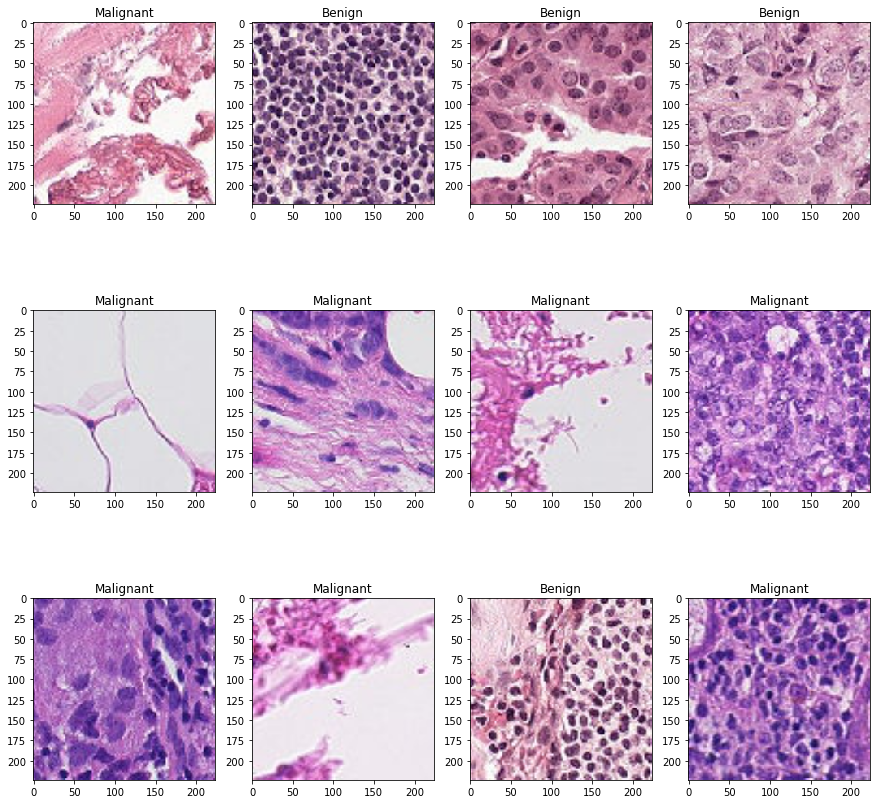

In [14]:
#CREATE TEST AND TRAIN DATASETS

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=2
)

w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [15]:
#CREATE DATAGENERATOR FOR DATA AUGMENTATION
BATCH_SIZE = 16

train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [16]:
#CREATE MODEL

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    return model

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1920)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1920)             7680      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610


In [17]:
#TRAIN MODEL

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\20182977\AppData\Local\Temp/ipykernel_15916/1884719658.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/15
20/20 [==============================] - ETA: 0s - loss: 0.7533 - accuracy: 0.5688 
Epoch 1: val_accuracy improved from -inf to 0.68750, saving model to weights.best.hdf5
20/20 [==============================] - 326s 16s/step - loss: 0.7533 - accuracy: 0.5688 - val_loss: 0.6210 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 2/15
20/20 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.6875 
Epoch 2: val_accuracy improved from 0.68750 to 0.75000, saving model to weights.best.hdf5
20/20 [==============================] - 351s 18s/step - loss: 0.6189 - accuracy: 0.6875 - val_loss: 0.5597 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 3/15
20/20 [==============================] - ETA: 0s - loss: 0.6320 - accuracy: 0.7031 
Epoch 3: val_accuracy did not improve from 0.75000
20/20 [==============================] - 265s 13s/step - loss: 0.6320 - accuracy: 0.7031 - val_loss: 0.5912 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 4/15
20/20 [=========================

<AxesSubplot:>

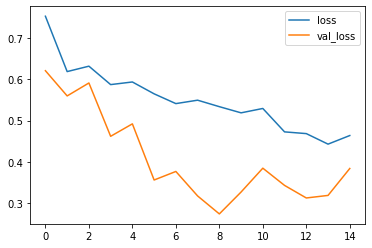

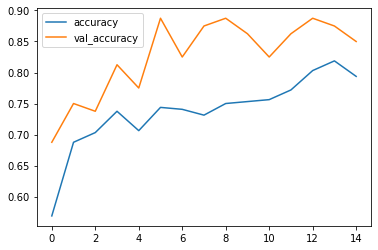

In [18]:
#CREATE LOSS PLOTS

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

Confusion matrix, without normalization
[[166  34]
 [ 40 160]]


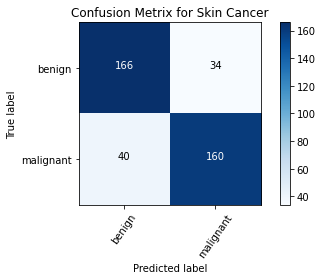

In [19]:
#CREATE CONFUSION MATRIX

from sklearn.metrics import classification_report
#pred = model.predict(X_test)
#pred = np.argmax(pred,axis = 1) 
#y_true = np.argmax(y_test,axis = 1)
Y_pred_tta = model.predict(X_test)
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

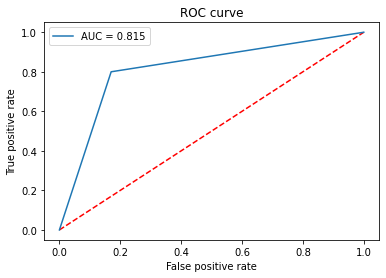

In [20]:
#CREATE ROC CURVE

from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()